# Fully Convolutional Networks
:label:`sec_fcn`

As discussed in :numref:`sec_semantic_segmentation`,
semantic segmentation
classifies images in pixel level.
A fully convolutional network (FCN)
uses a convolutional neural network to
transform image pixels to pixel classes :cite:`Long.Shelhamer.Darrell.2015`.
Unlike the CNNs that we encountered earlier
for image classification 
or object detection,
a fully convolutional network
transforms 
the height and width of intermediate feature maps
back to those of the input image:
this is achieved by
the transposed convolutional layer
introduced in :numref:`sec_transposed_conv`.
As a result,
the classification output
and the input image 
have a one-to-one correspondence 
in pixel level:
the channel dimension at any output pixel 
holds the classification results
for the input pixel at the same spatial position.


In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## The Model

Here we describe the basic design of the fully convolutional network model. 
As shown in :numref:`fig_fcn`,
this model first uses a CNN to extract image features,
then transforms the number of channels into
the number of classes
via a $1\times 1$ convolutional layer,
and finally transforms the height and width of
the feature maps
to those
of the input image via
the transposed convolution introduced in :numref:`sec_transposed_conv`. 
As a result,
the model output has the same height and width as the input image,
where the output channel contains the predicted classes
for the input pixel at the same spatial position.


![Fully convolutional network.](../img/fcn.svg)
:label:`fig_fcn`

Below, we [**use a ResNet-18 model pretrained on the ImageNet dataset to extract image features**]
and denote the model instance as `pretrained_net`.
The last few layers of this model
include a global average pooling layer
and a fully connected layer:
they are not needed
in the fully convolutional network.


In [2]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

Next, we [**create the fully convolutional network instance `net`**].
It copies all the pretrained layers in the ResNet-18
except for the final global average pooling layer
and the fully connected layer that are closest
to the output.


In [3]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

Given an input with height and width of 320 and 480 respectively,
the forward propagation of `net`
reduces the input height and width to 1/32 of the original, namely 10 and 15.


In [4]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

Next, we [**use a $1\times 1$ convolutional layer to transform the number of output channels into the number of classes (21) of the Pascal VOC2012 dataset.**]
Finally, we need to (**increase the height and width of the feature maps by 32 times**) to change them back to the height and width of the input image. 
Recall how to calculate 
the output shape of a convolutional layer in :numref:`sec_padding`. 
Since $(320-64+16\times2+32)/32=10$ and $(480-64+16\times2+32)/32=15$, we construct a transposed convolutional layer with stride of $32$, 
setting
the height and width of the kernel
to $64$, the padding to $16$.
In general,
we can see that
for stride $s$,
padding $s/2$ (assuming $s/2$ is an integer),
and the height and width of the kernel $2s$, 
the transposed convolution will increase
the height and width of the input by $s$ times.


In [5]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

## [**Initializing Transposed Convolutional Layers**]


We already know that
transposed convolutional layers can increase
the height and width of
feature maps.
In image processing, we may need to scale up
an image, i.e., *upsampling*.
*Bilinear interpolation*
is one of the commonly used upsampling techniques.
It is also often used for initializing transposed convolutional layers.

To explain bilinear interpolation,
say that 
given an input image
we want to 
calculate each pixel 
of the upsampled output image.
In order to calculate the pixel of the output image
at coordinate $(x, y)$, 
first map $(x, y)$ to coordinate $(x', y')$ on the input image, for example, according to the ratio of the input size to the output size. 
Note that the mapped $x'$ and $y'$ are real numbers. 
Then, find the four pixels closest to coordinate
$(x', y')$ on the input image. 
Finally, the pixel of the output image at coordinate $(x, y)$ is calculated based on these four closest pixels
on the input image and their relative distance from $(x', y')$. 

Upsampling of bilinear interpolation
can be implemented by the transposed convolutional layer 
with the kernel constructed by the following `bilinear_kernel` function. 
Due to space limitations, we only provide the implementation of the `bilinear_kernel` function below
without discussions on its algorithm design.


In [6]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

Let's [**experiment with upsampling of bilinear interpolation**] 
that is implemented by a transposed convolutional layer. 
We construct a transposed convolutional layer that 
doubles the height and weight,
and initialize its kernel with the `bilinear_kernel` function.


In [7]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

Read the image `X` and assign the upsampling output to `Y`. In order to print the image, we need to adjust the position of the channel dimension.


In [8]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

As we can see, the transposed convolutional layer increases both the height and width of the image by a factor of two.
Except for the different scales in coordinates,
the image scaled up by bilinear interpolation and the original image printed in :numref:`sec_bbox` look the same.


input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


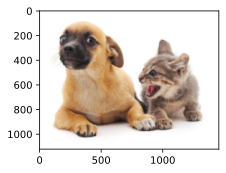

In [9]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

In a fully convolutional network, we [**initialize the transposed convolutional layer with upsampling of bilinear interpolation. For the $1\times 1$ convolutional layer, we use Xavier initialization.**]


In [10]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

## [**Reading the Dataset**]

We read
the semantic segmentation dataset
as introduced in :numref:`sec_semantic_segmentation`. 
The output image shape of random cropping is
specified as $320\times 480$: both the height and width are divisible by $32$.


In [11]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


## [**Training**]


Now we can train our constructed
fully convolutional network. 
The loss function and accuracy calculation here
are not essentially different from those in image classification of earlier chapters. 
Because we use the output channel of the
transposed convolutional layer to
predict the class for each pixel,
the channel dimension is specified in the loss calculation.
In addition, the accuracy is calculated
based on correctness
of the predicted class for all the pixels.


loss 0.411, train acc 0.870, test acc 0.852
416.9 examples/sec on [device(type='cuda', index=0)]


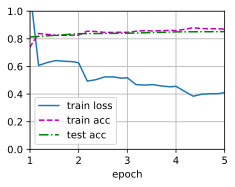

In [12]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## [**Prediction**]


When predicting, we need to standardize the input image
in each channel and transform the image into the four-dimensional input format required by the CNN.


In [13]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

To [**visualize the predicted class**] of each pixel, we map the predicted class back to its label color in the dataset.


In [14]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

Images in the test dataset vary in size and shape.
Since the model uses a transposed convolutional layer with stride of 32,
when the height or width of an input image is indivisible by 32,
the output height or width of the
transposed convolutional layer will deviate from the shape of the input image.
In order to address this issue,
we can crop multiple rectangular areas with height and width that are integer multiples of 32 in the image,
and perform forward propagation
on the pixels in these areas separately.
Note that
the union of these rectangular areas needs to completely cover the input image.
When a pixel is covered by multiple rectangular areas,
the average of the transposed convolution outputs
in separate areas for this same pixel
can be input to
the softmax operation
to predict the class.


For simplicity, we only read a few larger test images,
and crop a $320\times480$ area for prediction starting from the upper-left corner of an image.
For these test images, we
print their cropped areas,
prediction results,
and ground-truth row by row.


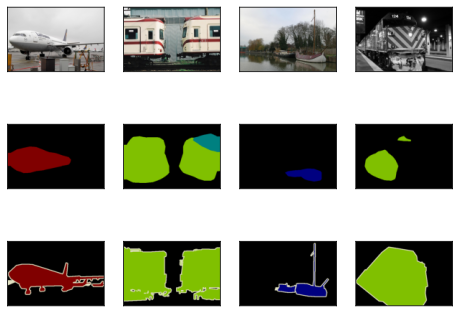

In [15]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

## Summary

* The fully convolutional network first uses a CNN to extract image features, then transforms the number of channels into the number of classes via a $1\times 1$ convolutional layer, and finally transforms the height and width of the feature maps to those of the input image via the transposed convolution.
* In a fully convolutional network, we can use upsampling of bilinear interpolation to initialize the transposed convolutional layer.


## Exercises

1. If we use Xavier initialization for the transposed convolutional layer in the experiment, how does the result change?
1. Can you further improve the accuracy of the model by tuning the hyperparameters?
1. Predict the classes of all pixels in test images.
1. The original fully convolutional network paper also uses outputs of some intermediate CNN layers :cite:`Long.Shelhamer.Darrell.2015`. Try to implement this idea.


[Discussions](https://discuss.d2l.ai/t/1582)
